# Read Me
**How to run this code:**<br>
Running this code is basically like running any iPython notebook, and then basically you run the cell sequentially.

**Implimentation and architecture details:**<br>
1. I imported MobileNetV3 small model from torchvision.models and then I changed the last layer to 9 classes.<br>
2. **Number of Epochs**: I trained for multiple epochs and then I found that the validation accuracy was not increasing after 15 epochs, so I stopped the training at 15 epochs.<br>
3. I would also save my Model only if the validation accuracy imporves in that epoch.
4. I implemented Automatic Mixed Precision to speed up the training
5. **LR Scheduler**: I implimented Reduce LR on Plateau and Cosine Annealing LR and I found that Cosine Annealing LR gave me better results.
6. **Optimizer**: I tried SGD optimizer, which gave good results, but I found that AdamW optimizer gave me better results.
7. **Architecture**: I experimented with ConvNeXt and Mobilenet V3 small and I found that both gave me similar results.
8. **Hyper Parameters**: I experimented with several hyper parameters but the hyper parameters that gave met the best accauracy are the ones that are implimented in this notebook below
9. **Data Augmentation**: I experimented with Gaussian Blur and Color Jitter for brightness becasue thats in the write up it was mentioned that, thats how the test imaged might be different from the training images.
10. I used Image Folder Dataset to load the data and I used 80% of the data for training and 20% for validation, and wrote a custom dataset class to load the test data.
11. **Loss Function**: I used Cross Entropy Loss as the loss function because it is a multi class classification problem.
12. I was able to get 94.7654% validation accuracy.

In [ ]:
# !unzip ML\ Assessment\ Data.zip

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as ttf

import os
import os.path as osp

from tqdm import tqdm
from PIL import Image
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Hyperparameters

In [2]:

batch_size = 128
lr = 0.001
epochs = 15

# Dataset & DataLoader

In [3]:
# Data directory 
TRAIN_DIR = 'train/'
VAL_DIR = 'val/'
TEST_DIR = 'test/'

# Data augmentation for training
train_transforms = [
        ttf.ColorJitter(brightness=(0.5, 1.5)),
        # ttf.GaussianBlur(7, sigma=(0.1, 2.0)),
        ttf.Resize((500, 600)),
        ttf.CenterCrop(300),
        ttf.ToTensor(),  # Finally converts PIL image to tensor so we can train w. pytorch

        ]

# Data augmentation for validation
val_transforms = [
                ttf.Resize((500, 600)),
                ttf.CenterCrop(300),
                ttf.ToTensor()]

# Dataset class for training and validation
train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR,
                                                 transform=ttf.Compose(train_transforms))
val_dataset = torchvision.datasets.ImageFolder(VAL_DIR,
                                               transform=ttf.Compose(val_transforms))

# Dataloader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        drop_last=True, num_workers=4, pin_memory=True)

idx_to_class mapping:  {0: '2.0 mm x26 mm', 1: '2.0 mm x28 mm', 2: '2.8 mm x22 mm', 3: '3.5 mm x19 mm', 4: '3.5 mm x22 mm', 5: '3.5 mm x28 mm', 6: '3.5 mm x30 mm', 7: '4.2 mm x22 mm', 8: '4.2 mm x30 mm'}
Example image from dataset: 
Class:  2.0 mm x26 mm


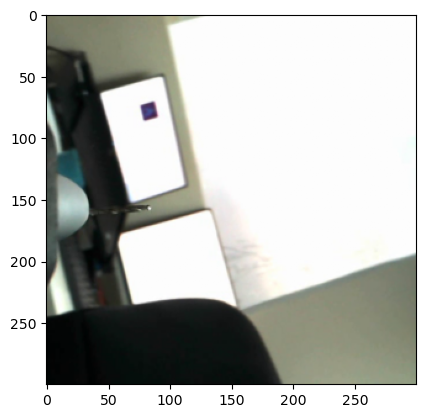

In [4]:
# dataset to class names mapping
class_to_idx = train_dataset.class_to_idx
# index to class names mapping
idx_to_class = {v: k[0]+'.'+ k[1] + ' mm ' + k[2:]+ ' mm'for k, v in class_to_idx.items()}
print('idx_to_class mapping: ', idx_to_class)
numb_classes = len(train_dataset.classes)

# display some images
def imshow(img):
    '''Display an image
    params: img - the image to display
    '''

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print some random training images
for img, label in val_loader:
    label = label[0]
    # map label to class name
    print('Example image from dataset: ')
    print('Class: ', idx_to_class[label.item()])
    imshow(img[0])
    break


In [16]:
# draw a bar chart of the number of images per class
def draw_bar_chart(dataset):
    '''Draw a bar chart of the number of images per class
    params: dataset - the dataset to draw the bar chart for
    '''
    class_count = [0] * len(dataset.classes)
    for _, label in dataset:
        class_count[label] += 1
    plt.bar(range(len(dataset.classes)), class_count)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.show()

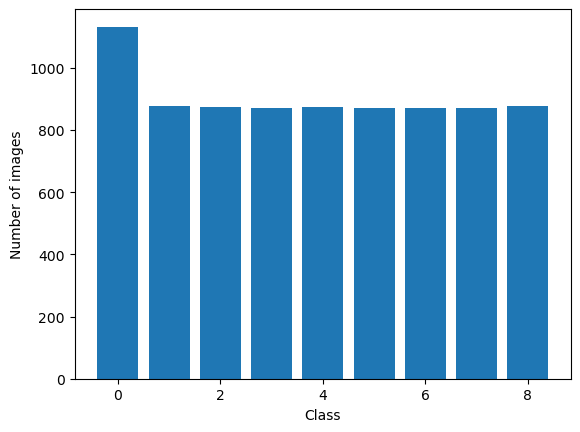

In [17]:
# draw bar chart for training
draw_bar_chart(train_dataset)

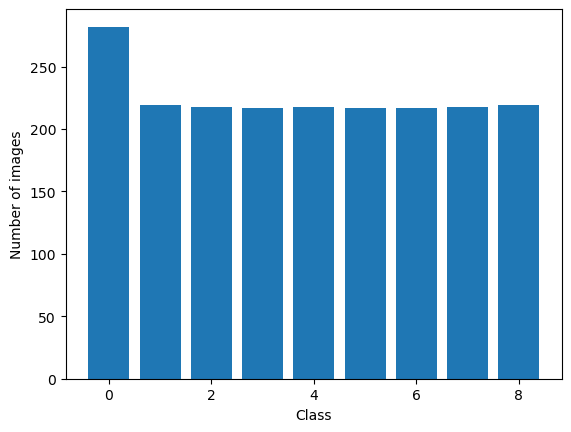

In [18]:
# draw bar chart for validation set
draw_bar_chart(val_dataset)

# Setup everything for training

# Let's train!

In [5]:
# import mobilenet v3 small from torchvision models and modify it to fit our problem
mobilenet = torchvision.models.mobilenet_v3_small(weights='IMAGENET1K_V1')
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(576, numb_classes)
)
mobilenet.to(device)
from torchsummary import summary
print(summary(mobilenet, (3, 300, 300)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             432
       BatchNorm2d-2         [-1, 16, 150, 150]              32
         Hardswish-3         [-1, 16, 150, 150]               0
            Conv2d-4           [-1, 16, 75, 75]             144
       BatchNorm2d-5           [-1, 16, 75, 75]              32
              ReLU-6           [-1, 16, 75, 75]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 75, 75]               0
           Conv2d-13           [-1, 16, 75, 75]             256
      BatchNorm2d-14           [-1, 16,

In [6]:
# define loss function and optimizer and scheduler for training
optimizer = optim.AdamW(mobilenet.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
scaler = torch.cuda.amp.GradScaler()

In [7]:
# initialize lists to store training and validation loss and accuracy
val_max = 0

In [8]:
# parameters to keep track of training
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [ ]:
# Training loop
for epoch in tqdm(range(epochs)):
    mobilenet.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

    # initialize variables to store training loss and accuracy
    num_correct = 0
    total_loss = 0
 
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        # Mixed precision training for faster training
        with torch.cuda.amp.autocast():     
            outputs = mobilenet(x)
            loss = criterion(outputs, y)

        # Update # correct & loss as we go
        num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
        total_loss += float(loss)

        train_acc = 100 * num_correct / ((i + 1) * batch_size)
        train_loss = float(total_loss / (i + 1))
        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc="{:.04f}%".format(train_acc),
            loss="{:.04f}".format(train_loss),
            num_correct=num_correct,
            lr="{:.16f}".format(float(optimizer.param_groups[0]['lr'])))
        
        # Backprop and update weights with mixed precision
        scaler.scale(loss).backward() # This is a replacement for loss.backward() with mixed precision
        scaler.step(optimizer) # This is a replacement for optimizer.step() with mixed precision
        scaler.update() # This is something added just for FP16 support, for mixed precision training

        scheduler.step() # We told scheduler T_max that we'd call step() (len(train_loader) * epochs) many times.

        batch_bar.update() # Update tqdm bar
    batch_bar.close() # need this to close the tqdm bar

    # Print some metrics
    train_acc = 100 * num_correct / (len(train_loader) * batch_size)
    train_loss = float(total_loss / len(train_loader))
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print("Epoch {}/{}: Train Acc {:.04f}%, Train Loss {:.04f}, Learning Rate {:.16f}".format(
        epoch + 1,
        epochs,
        train_acc,
        train_loss,
        float(optimizer.param_groups[0]['lr'])))


    # Validation loop
    mobilenet.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
    num_correct = 0
    total_val_loss = 0
    for i, (x, y) in enumerate(val_loader):

        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
          with torch.cuda.amp.autocast(): 
            outputs = mobilenet(x)
            valid_loss = criterion(outputs, y)

        num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
        total_val_loss += float(valid_loss)
        
        batch_bar.set_postfix(acc="{:.04f}%".format(100 * num_correct / ((i + 1) * batch_size)))
        batch_bar.update()
    batch_bar.close()
    val = 100 * num_correct / len(val_dataset)
    val_loss = float(total_val_loss / len(val_loader))
    val_losses.append(val_loss)
    val_accs.append(val)
    print("Validation Accuracy: {:.04f}%".format(val), 'Validation Loss: {:.04f}'.format(val_loss))

    if val > val_max:
      val_max = val
      f_name = 'mobilenet.pt'
      print('Saving model with validation accuracy {:.04f}%'.format(val))
      torch.save(mobilenet, f_name)


# Plot the training and validation loss

Text(0.5, 1.0, 'Loss vs Epoch')

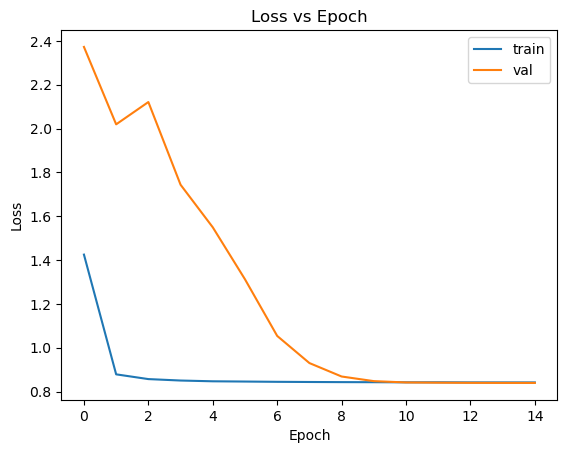

In [10]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')

# Plot the training and validation accuracy

Text(0.5, 1.0, 'Accuracy vs Epoch')

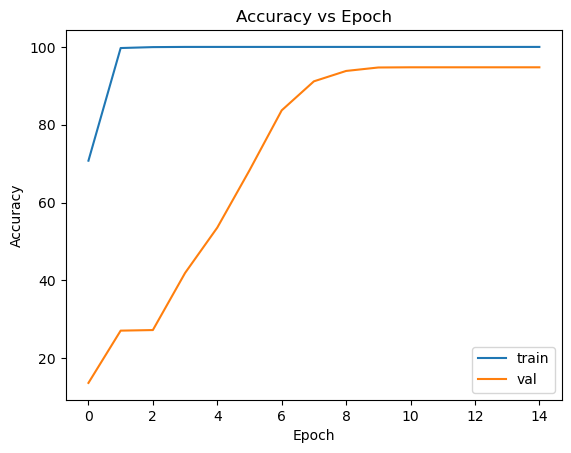

In [11]:
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')

# Classification Task: Validation

In [12]:
mobilenet.load_state_dict(torch.load('mobilenet.pt', map_location=torch.device(device=device)).state_dict())

<All keys matched successfully>

In [13]:
mobilenet.eval()
batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
num_correct = 0
for i, (x, y) in enumerate(val_loader):

    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
      with torch.cuda.amp.autocast():
        outputs = mobilenet(x)

    num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
    batch_bar.set_postfix(acc="{:.04f}%".format(100 * num_correct / ((i + 1) * batch_size)))

    batch_bar.update()
    
batch_bar.close()
print("Validation Accuracy: {:.04f}%".format(100 * num_correct / len(val_dataset)))

Validation Accuracy: 94.7654%


# Classification Task: Test

In [14]:
# Dataset class for test data
class ClassificationTestSet(Dataset):
    # It's possible to load test set data using ImageFolder without making a custom class.
    # See if you can think it through!

    def __init__(self, data_dir, transforms):
        '''
        data_dir: Path to the directory containing the test images
        transforms: Transformations to be applied to the images
        '''
        self.data_dir = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in data_dir
        self.img_paths = list(map(lambda fname: osp.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx])), self.img_paths[idx].split('/')[-1]

In [15]:
# Test dataset and dataloader classes
test_dataset = ClassificationTestSet(TEST_DIR, ttf.Compose(val_transforms))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         drop_last=False, num_workers=4, pin_memory=True)

In [16]:
mobilenet.eval()
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, position=0, leave=False, desc='Test')

res = []
for x, file_name in test_loader:

    x = x.cuda()
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            outputs = mobilenet(x)
        y_hat = torch.argmax(outputs, axis=1)
        res.extend(list(zip(file_name, y_hat.cpu().numpy())))
    
    batch_bar.update()
    
batch_bar.close()

In [17]:
# map the labels to the classes
res = list(map(lambda x: (x[0], idx_to_class[x[1]]), res))
print('Length of test set predictions:', len(res))

Length of test set predictions: 2025


In [18]:
# convert to a dataframe and print the file name and the predicted class
df = pd.DataFrame(res, columns=['file_name', 'predicted_class'])
print(df)

           file_name predicted_class
0     frame10002.png   3.5 mm x22 mm
1     frame10006.png   3.5 mm x22 mm
2     frame10014.png   3.5 mm x22 mm
3     frame10016.png   3.5 mm x22 mm
4     frame10022.png   3.5 mm x22 mm
...              ...             ...
2020   frame9976.png   3.5 mm x22 mm
2021   frame9980.png   3.5 mm x22 mm
2022   frame9992.png   3.5 mm x22 mm
2023   frame9996.png   3.5 mm x22 mm
2024   frame9998.png   3.5 mm x22 mm

[2025 rows x 2 columns]


In [19]:
#print the number of images in each class
print('Predicted class:', 'Number of images')
print(df['predicted_class'].value_counts())

Predicted class: Number of images
2.0 mm x26 mm    282
2.0 mm x28 mm    220
4.2 mm x30 mm    219
3.5 mm x22 mm    218
4.2 mm x22 mm    218
2.8 mm x22 mm    218
3.5 mm x30 mm    217
3.5 mm x19 mm    217
3.5 mm x28 mm    216
Name: predicted_class, dtype: int64


<AxesSubplot:>

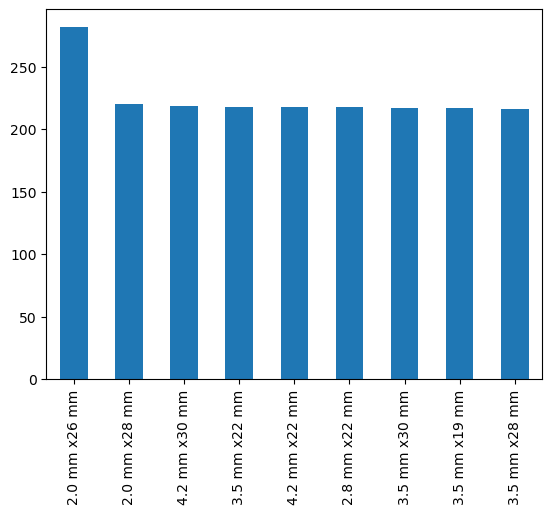

In [20]:
#plot the number of images in predicted classes
df['predicted_class'].value_counts().plot(kind='bar')

# Discussion
This distribution looks very similar to the distribution of the training data and the validation data from which the test data was sampled. This means that the model is and rest of the system is working as expected.

# Extra

In [21]:
# save the dataframe to a csv file
df.to_csv('mobilenet_predictions.csv', index=False)

In [22]:
#save the idx_to_class dictionary to a json file
import json
with open('idx_to_class.json', 'w') as f:
    json.dump(idx_to_class, f)

In [24]:
# load the idx_to_class dictionary from a json file
with open('idx_to_class.json', 'r') as f:
    idx_to_class = json.load(f)

print('idx_to_class:', idx_to_class)

idx_to_class: {'0': '2.0 mm x26 mm', '1': '2.0 mm x28 mm', '2': '2.8 mm x22 mm', '3': '3.5 mm x19 mm', '4': '3.5 mm x22 mm', '5': '3.5 mm x28 mm', '6': '3.5 mm x30 mm', '7': '4.2 mm x22 mm', '8': '4.2 mm x30 mm'}
